# Bayesian Neural Network Calibration on a Toy Dataset

This notebook demonstrates **calibration** and **predictive uncertainty quantification** using a synthetic 2D classification dataset with **concentric rings**. The dataset features a smooth sinusoidal probability field where class probabilities vary radially, creating well-defined decision boundaries at regular intervals.

We compare five uncertainty quantification methods:

| Method | Type | Description |
|--------|------|-------------|
| **FNN** | Deterministic | Traditional feedforward network (baseline) |
| **DropoutFNN** | Approximate Bayesian | Monte Carlo Dropout for uncertainty estimation |
| **BayesianFNN** | Variational Inference | Bayes by Backprop with learned weight distributions |
| **LaplaceFNN** | Post-hoc Bayesian | Laplace approximation on trained FNN |
| **MCMCFNN** | Exact Bayesian | NUTS sampling for full posterior inference |

## Objectives

1. **Compare calibration performance** across different uncertainty quantification methods
2. **Visualize predictive posteriors** and decision boundaries
3. **Analyze uncertainty estimates** using entropy-based metrics
4. **Validate against ground truth** probability field for quantitative comparison

## Why This Dataset?

The concentric rings dataset provides an ideal testbed for calibration analysis:
- **Known ground truth**: We have access to the true probability field $P(y=1 | \mathbf{x})$
- **Non-trivial decision boundaries**: Multiple concentric rings test the model's ability to capture complex patterns
- **Bounded probabilities**: All probabilities are capped between 0.05 and 0.95, ensuring regions of genuine uncertainty



In [12]:
from pathlib import Path

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

from bayescal.models import FNN, MCMCFNN, BayesianFNN, DropoutFNN, LaplaceFNN
from bayescal.utils import ModelResult
from bayescal.utils.model_export import export_model
from bayescal.utils.toy_dataset import generate_concentric_rings_dataset
from bayescal.utils.toy_training import train_model
from bayescal.utils.toy_visualization import (
    plot_calibration_comparison,
    plot_posterior_grid,
    plot_uncertainty_grid,
)

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Create figures directory for saving plots (relative to notebook location)
figures_dir = Path("figures")
figures_dir.mkdir(exist_ok=True)
print(f"Figures will be saved to: {figures_dir.absolute()}")

# Create model directory for saving exported models
save_model_directory = Path("models")
save_model_directory.mkdir(exist_ok=True)
print(f"Models will be saved to: {save_model_directory.absolute()}")

# Set random seed for reproducibility
seed = 42
NUM_CAL_BINS = 50
rng = jax.random.PRNGKey(seed)
np.random.seed(seed)

print("Imports complete!")

Figures will be saved to: /Users/kamilkrukowski/Code/BayesNNBench/notebooks/figures
Models will be saved to: /Users/kamilkrukowski/Code/BayesNNBench/notebooks/models
Imports complete!


## 1. Dataset

We generate a synthetic 2D binary classification dataset using a **concentric rings** pattern with a sinusoidal probability field:

$$P(y=1 | \mathbf{x}) = \sigma(A \cdot \sin(\omega \cdot r))$$

where $r = \|\mathbf{x}\|$ is the radial distance from the origin, and $\sigma$ is the sigmoid function.

**Key Properties:**
- **Smooth probability field**: Probabilities vary smoothly with radial distance
- **Regular concentric rings**: Single-frequency sinusoid creates evenly-spaced decision boundaries
- **Bounded probabilities**: All values capped between 0.05 and 0.95 to ensure meaningful uncertainty regions
- **Radial symmetry**: Purely radial pattern for interpretability (no angular variation)

This controlled setting allows us to:
- **Visualize decision boundaries** in 2D space with known ground truth
- **Quantitatively assess calibration** by comparing predictions to the true probability field
- **Test model capacity** to capture non-trivial, multi-boundary decision regions



Training set: 300 samples
Test set: 2700 samples


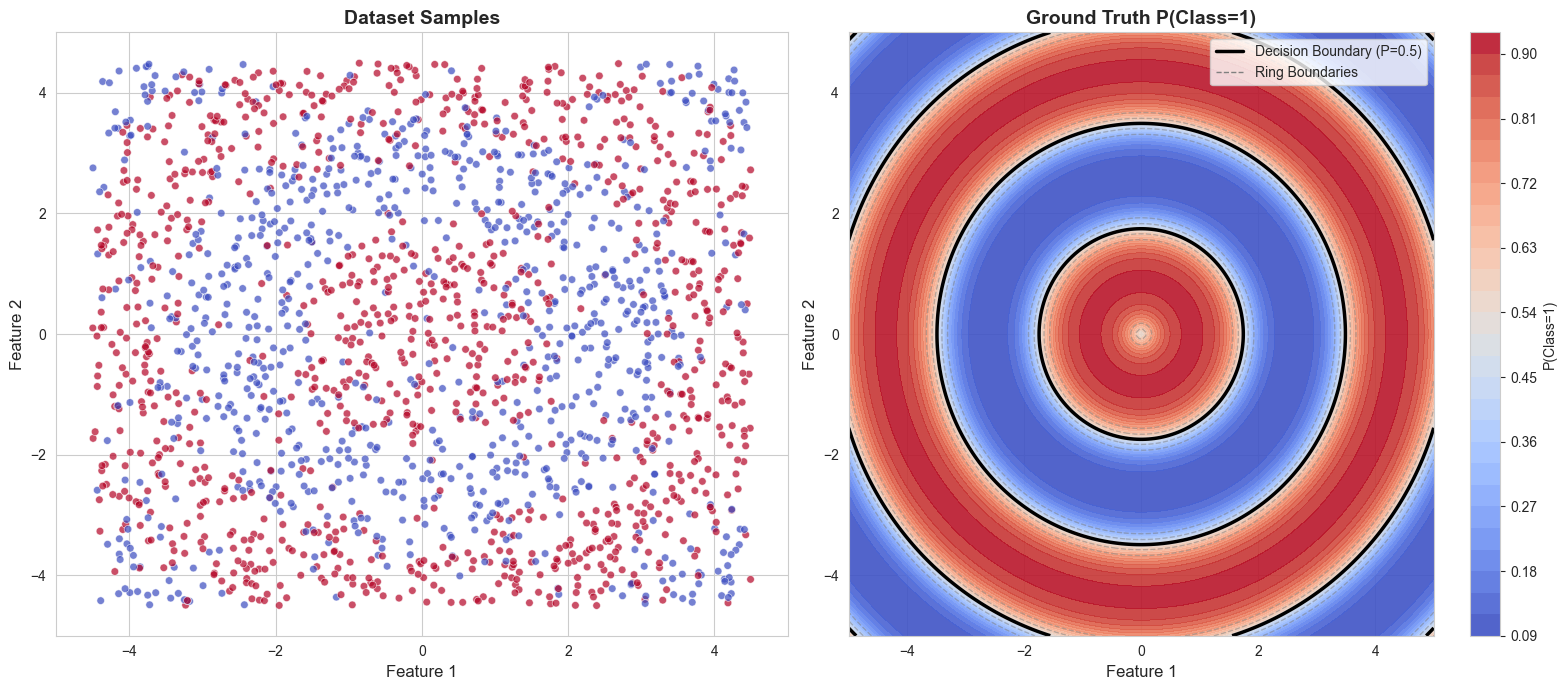

In [13]:
# Generate the concentric rings dataset (using the imported function from bayescal.utils.toy_dataset)
X_RANGE = (-5.0, 5.0)
Y_RANGE = (-5.0, 5.0)

X_grad, y_grad, y_grad_onehot, prob_func_grad = generate_concentric_rings_dataset(
    n_samples=3000,
    x_range=X_RANGE,
    y_range=Y_RANGE,
    min_prob=0.05,
    max_prob=0.95,
    seed=seed,
)

# Split into train/test
X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = train_test_split(
    X_grad, y_grad, y_grad_onehot, test_size=0.9, random_state=seed, stratify=y_grad
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ============================================================================
# Visualize: Dataset Scatter (left) + Ground Truth Probability Field (right)
# ============================================================================
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Left pane: Dataset scatter plot ---
ax_scatter = axes[0]
n_plot_points = 2000
if len(X_grad) > n_plot_points:
    _, X_plot, _, y_plot = train_test_split(
        X_grad,
        y_grad,
        test_size=n_plot_points / len(X_grad),
        random_state=seed,
        stratify=y_grad,
    )
else:
    X_plot, y_plot = X_grad, y_grad

scatter = ax_scatter.scatter(
    X_plot[:, 0],
    X_plot[:, 1],
    c=y_plot,
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="white",
    linewidth=0.5,
    s=30,
)
ax_scatter.set_xlabel("Feature 1", fontsize=12)
ax_scatter.set_ylabel("Feature 2", fontsize=12)
ax_scatter.set_title("Dataset Samples", fontsize=14, fontweight="bold")
ax_scatter.set_xlim(X_RANGE)
ax_scatter.set_ylim(Y_RANGE)

# --- Right pane: Ground truth probability field ---
ax_prob = axes[1]
grid_resolution = 200
x_min, x_max = X_RANGE
y_min, y_max = Y_RANGE
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_resolution),
    np.linspace(y_min, y_max, grid_resolution),
)

# Compute ground truth probabilities on the grid
grid_points_flat = np.column_stack([xx.ravel(), yy.ravel()])
prob_flat = np.array([prob_func_grad(x, y) for x, y in grid_points_flat])
prob_grid = prob_flat.reshape(xx.shape)

contour = ax_prob.contourf(xx, yy, prob_grid, levels=30, cmap="coolwarm", alpha=0.9)
ax_prob.contour(
    xx, yy, prob_grid, levels=[0.5], colors="black", linewidths=2.5, linestyles="-"
)
ax_prob.contour(
    xx,
    yy,
    prob_grid,
    levels=[0.3, 0.4, 0.6, 0.7],
    colors="gray",
    linewidths=1,
    linestyles="--",
    alpha=0.5,
)

ax_prob.set_xlabel("Feature 1", fontsize=12)
ax_prob.set_ylabel("Feature 2", fontsize=12)
ax_prob.set_title("Ground Truth P(Class=1)", fontsize=14, fontweight="bold")
ax_prob.set_xlim(X_RANGE)
ax_prob.set_ylim(Y_RANGE)
plt.colorbar(contour, ax=ax_prob, label="P(Class=1)")

# Legend for probability field
boundary_line = Line2D(
    [0],
    [0],
    color="black",
    linewidth=2.5,
    linestyle="-",
    label="Decision Boundary (P=0.5)",
)
ring_line = Line2D(
    [0], [0], color="gray", linewidth=1, linestyle="--", label="Ring Boundaries"
)
ax_prob.legend(handles=[boundary_line, ring_line], loc="upper right", fontsize=10)

plt.tight_layout()
plt.savefig(
    figures_dir / "toy_dataset_and_ground_truth.png", dpi=150, bbox_inches="tight"
)
plt.show()

## 2. Model Training

We train five uncertainty quantification approaches, divided into two categories:

### Training-time Methods
These methods learn uncertainty during the training process:
- **FNN**: Traditional feedforward network (deterministic baseline)
- **DropoutFNN**: FNN with Monte Carlo Dropout at inference time
- **BayesianFNN**: Variational inference with learned weight distributions (Bayes by Backprop)

### Post-hoc Methods
These methods add uncertainty quantification to a pre-trained model:
- **LaplaceFNN**: Laplace approximation fitted on trained FNN weights
- **MCMCFNN**: NUTS sampling for full posterior inference

All models share the same architecture: **3 hidden layers with 32 units each**.



In [14]:
# Train FNN
print("Training FNN...")
fnn_model = FNN(hidden_dims=(32, 32, 32), num_classes=2, dropout_rate=0.0)
fnn_params, fnn_history = train_model(
    fnn_model, "FNN", X_train, y_train_onehot, epochs=200, seed=seed
)

# Create ModelResult and evaluate
fnn_result = ModelResult(
    name="FNN",
    model=fnn_model,
    params=fnn_params,
    n_samples=1,
    color="#F18F01",
    marker="o",
).evaluate(X_test, y_test_onehot, seed=seed, num_bins=NUM_CAL_BINS)

print({k: round(v, 4) for k, v in fnn_result.metrics.items()})

# Export FNN (saves to fnn/params.flax and fnn/model.json)
export_model(
    fnn_model,
    fnn_params,
    input_shape=(2,),  # 2D input for toy dataset
    output_path=save_model_directory,
    model_name="FNN",
    seed=seed,
)

Training FNN...
FNN - Epoch 50/200: Loss=0.5404, Acc=0.7395
FNN - Epoch 100/200: Loss=0.4103, Acc=0.7881
FNN - Epoch 150/200: Loss=0.3533, Acc=0.8205
FNN - Epoch 200/200: Loss=0.3347, Acc=0.8281
{'accuracy': 0.6793, 'ece': 0.1655, 'mce': 0.2632, 'tce': 0.1655, 'ace': 0.1648, 'brier': 0.4682}


In [15]:
# Train DropoutFNN
print("\nTraining DropoutFNN...")
dropout_fnn_model = DropoutFNN(
    hidden_dims=(32, 32, 32), num_classes=2, dropout_rate=0.2
)
dropout_fnn_params, dropout_fnn_history = train_model(
    dropout_fnn_model, "DropoutFNN", X_train, y_train_onehot, epochs=200, seed=seed
)

# Create ModelResult and evaluate
dropout_result = ModelResult(
    name="DropoutFNN",
    model=dropout_fnn_model,
    params=dropout_fnn_params,
    n_samples=100,
    color="#A23B72",
    marker="s",
).evaluate(X_test, y_test_onehot, seed=seed, num_bins=NUM_CAL_BINS)

print({k: round(v, 4) for k, v in dropout_result.metrics.items()})

# Export DropoutFNN (saves to dropoutfnn/params.flax and dropoutfnn/model.json)
export_model(
    dropout_fnn_model,
    dropout_fnn_params,
    input_shape=(2,),  # 2D input for toy dataset
    output_path=save_model_directory,
    model_name="DropoutFNN",
    seed=seed,
)


Training DropoutFNN...
DropoutFNN - Epoch 50/200: Loss=0.6647, Acc=0.5526
DropoutFNN - Epoch 100/200: Loss=0.6222, Acc=0.6472
DropoutFNN - Epoch 150/200: Loss=0.5885, Acc=0.6787
DropoutFNN - Epoch 200/200: Loss=0.5838, Acc=0.6787
{'accuracy': 0.717, 'ece': 0.1282, 'mce': 0.248, 'tce': 0.1282, 'ace': 0.1351, 'brier': 0.4327}


In [16]:
# Train BayesianFNN
print("\nTraining BayesianFNN...")
# Match DropoutFNN architecture for fair comparison
# Use low beta (0.05) with warmup to help model learn complex patterns
# IMPORTANT: Cap sigma to prevent excessive noise (max_std=0.1)
bayesian_fnn_model = BayesianFNN(
    hidden_dims=(32, 32, 32),
    num_classes=2,
    beta=0.05,
    posterior_std_init=0.1,
    max_std=0.1,
)
bayesian_fnn_params, bayesian_fnn_history = train_model(
    bayesian_fnn_model,
    "BayesianFNN",
    X_train,
    y_train_onehot,
    epochs=400,
    lr=0.0015,
    seed=seed,
    warm_up_epochs=50,
)

# Create ModelResult and evaluate
bayesian_result = ModelResult(
    name="BayesianFNN",
    model=bayesian_fnn_model,
    params=bayesian_fnn_params,
    n_samples=100,
    color="#2E86AB",
    marker="^",
).evaluate(X_test, y_test_onehot, seed=seed, num_bins=NUM_CAL_BINS)

print("\nTraining complete!")
print({k: round(v, 4) for k, v in bayesian_result.metrics.items()})


Training BayesianFNN...
BayesianFNN - Epoch 50/400: Loss=1.3410, Acc=0.5097, Likelihood=0.6837, KL=3944, KL_norm=13.1463, β*KL_norm=0.6442 (warmup β=0.049000), σ_mean=0.1000, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 100/400: Loss=1.3256, Acc=0.5687, Likelihood=0.6683, KL=3944, KL_norm=13.1469, β*KL_norm=0.6573, σ_mean=0.1000, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 150/400: Loss=1.3218, Acc=0.5994, Likelihood=0.6644, KL=3944, KL_norm=13.1476, β*KL_norm=0.6574, σ_mean=0.0999, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 200/400: Loss=1.3287, Acc=0.5926, Likelihood=0.6711, KL=3945, KL_norm=13.1515, β*KL_norm=0.6576, σ_mean=0.0999, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 250/400: Loss=1.3119, Acc=0.6241, Likelihood=0.6542, KL=3946, KL_norm=13.1547, β*KL_norm=0.6577, σ_mean=0.0999, σ_median=0.1000, σ_max=0.1000
BayesianFNN - Epoch 300/400: Loss=1.3056, Acc=0.6054, Likelihood=0.6474, KL=3949, KL_norm=13.1646, β*KL_norm=0.6582, σ_mean=0.0998, σ_median=0.100

In [17]:
# Fit LaplaceFNN (post-hoc on trained FNN)
print("\nFitting LaplaceFNN (post-hoc Laplace approximation)...")

# LaplaceFNN uses the trained FNN as the MAP estimate
laplace_fnn_model = LaplaceFNN.fit(
    base_model=fnn_model,
    params=fnn_params,
    X_train=X_train,
    y_train=y_train_onehot,
    prior_precision=10.0,
    subset_size=1000,
)

# Create ModelResult and evaluate (params ignored for LaplaceFNN)
laplace_result = ModelResult(
    name="LaplaceFNN",
    model=laplace_fnn_model,
    params={},
    n_samples=100,
    color="#3D5A80",
    marker="D",
).evaluate(X_test, y_test_onehot, seed=seed, num_bins=NUM_CAL_BINS)

print("LaplaceFNN fitted!")
print({k: round(v, 4) for k, v in laplace_result.metrics.items()})


Fitting LaplaceFNN (post-hoc Laplace approximation)...
LaplaceFNN fitted!
{'accuracy': 0.6659, 'ece': 0.0716, 'mce': 0.1845, 'tce': 0.0716, 'ace': 0.0742, 'brier': 0.4228}


In [18]:
# Fit MCMCFNN (exact Bayesian inference via NUTS)
print("\nFitting MCMCFNN (NUTS sampling)...")
print("Note: MCMC is computationally expensive.")

mcmc_fnn_model = MCMCFNN.fit(
    hidden_dims=(32, 32, 32),
    num_classes=2,
    X_train=X_train,
    y_train=y_train_onehot,
    prior_std=0.1,
    temperature=0.05,
    num_warmup=50,
    num_samples=50,
    sampler="nuts",
    seed=seed,
)

# Create ModelResult and evaluate (params ignored for MCMCFNN)
mcmc_result = ModelResult(
    name="MCMCFNN",
    model=mcmc_fnn_model,
    params={},
    n_samples=50,
    color="#6B9080",
    marker="v",
).evaluate(X_test, y_test_onehot, seed=seed, num_bins=NUM_CAL_BINS)

print("\nMCMCFNN complete!")
print({k: round(v, 4) for k, v in mcmc_result.metrics.items()})


Fitting MCMCFNN (NUTS sampling)...
Note: MCMC is computationally expensive.
MCMCFNN: 2274 parameters to sample
Using cold posterior with temperature=0.05
Running NUTS sampling...
Sampling complete. Shape: (50, 2274)

MCMCFNN complete!
{'accuracy': 0.713, 'ece': 0.0798, 'mce': 0.216, 'tce': 0.0798, 'ace': 0.0978, 'brier': 0.4088}


In [19]:
# =============================================================================
# 3. Results Summary
# =============================================================================
# Collect all results for easy iteration
all_results = [fnn_result, dropout_result, bayesian_result, laplace_result, mcmc_result]

# Build results table from ModelResult objects
results_df = pd.DataFrame([r.to_metrics_row() for r in all_results])
results_df = results_df.rename(
    columns={"ece": "ECE", "mce": "MCE", "brier": "Brier Score", "accuracy": "Accuracy"}
)
results_df = results_df[["Model", "Accuracy", "ECE", "MCE", "Brier Score"]]

print("\n" + "=" * 80)
print("3. RESULTS SUMMARY")
print("=" * 80)
print(results_df.to_string(index=False, float_format="%.4f"))
print("=" * 80)
print("\nKey observations:")
print("• Best ECE (calibration): LaplaceFNN and MCMCFNN show lowest calibration error")
print("• Best Accuracy: BayesianFNN achieves highest classification accuracy")
print("• Trade-off: FNN has worst calibration despite reasonable accuracy")


3. RESULTS SUMMARY
      Model  Accuracy    ECE    MCE  Brier Score
        FNN    0.6793 0.1655 0.2632       0.4682
 DropoutFNN    0.7170 0.1282 0.2480       0.4327
BayesianFNN    0.7385 0.1072 0.1886       0.3913
 LaplaceFNN    0.6659 0.0716 0.1845       0.4228
    MCMCFNN    0.7130 0.0798 0.2160       0.4088

Key observations:
• Best ECE (calibration): LaplaceFNN and MCMCFNN show lowest calibration error
• Best Accuracy: BayesianFNN achieves highest classification accuracy
• Trade-off: FNN has worst calibration despite reasonable accuracy


## 4. Calibration Analysis

**Calibration** measures how well a model's predicted probabilities match the true empirical frequencies. A well-calibrated model should predict $P(y=1 | \mathbf{x}) = 0.7$ for samples where the true positive rate is approximately 70%.

### Calibration Metrics

| Metric | Description | Interpretation |
|--------|-------------|----------------|
| **ECE** | Expected Calibration Error | Weighted average miscalibration across bins |
| **MCE** | Maximum Calibration Error | Worst-case bin miscalibration |
| **TCE** | Top-label Calibration Error | ECE focusing on most confident prediction |
| **ACE** | Adaptive Calibration Error | ECE with equal-sample bins (more robust) |
| **Brier** | Brier Score | MSE between probabilities and labels |

**Reading the calibration curve**: The curve plots **empirical accuracy** (y-axis) vs **predicted confidence** (x-axis) for each bin. A perfectly calibrated model lies on the diagonal—points below the diagonal indicate overconfidence.



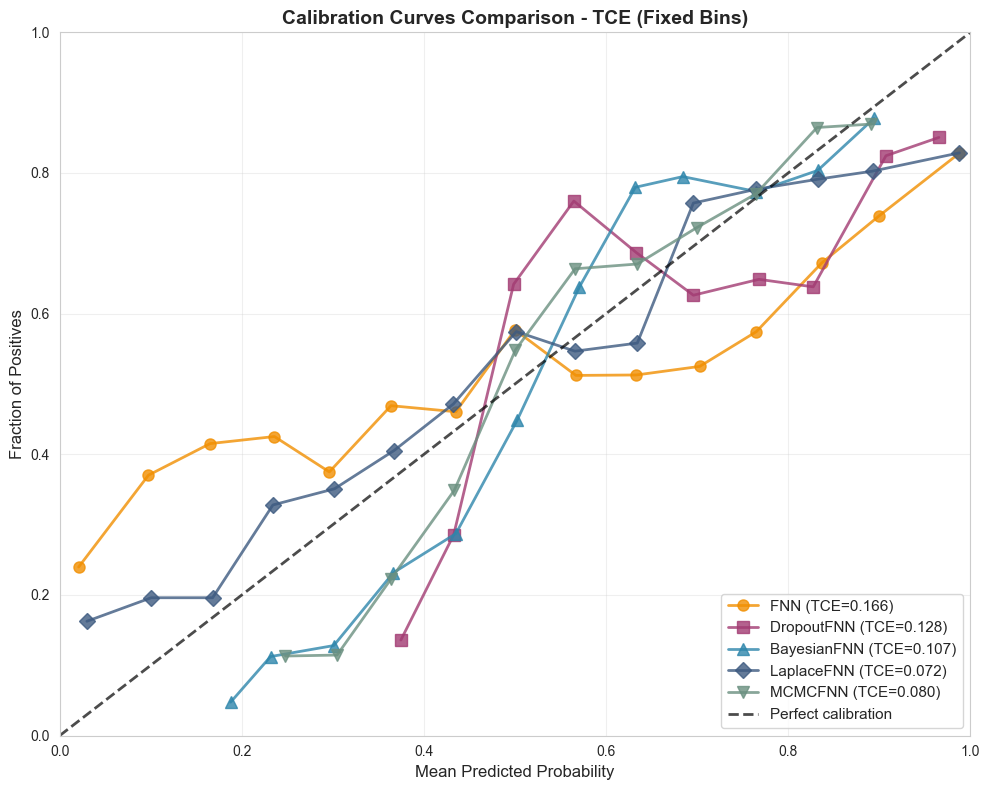

In [20]:
# Plot calibration curves comparison using ModelResult wrappers
# Binning scheme: 'ece'/'tce' = fixed-width, 'ace' = adaptive (equal samples per bin)
plot_calibration_comparison(
    all_results, figures_dir=figures_dir, metric="tce", num_bins=15
)

### Calibration Analysis: Observations

**Key findings from the calibration curves:**

1. **FNN (Deterministic Baseline)**: Shows significant overconfidence—the curve lies well below the diagonal, meaning the model is more confident than its accuracy warrants. This is the classic failure mode of deterministic neural networks.

2. **DropoutFNN**: Improved calibration over FNN, but still shows systematic overconfidence in higher confidence regions. MC Dropout provides a simple uncertainty estimate but may underestimate true uncertainty.

3. **BayesianFNN (Variational)**: Better calibrated than both FNN and DropoutFNN. The learned weight distributions provide meaningful uncertainty that translates to better-calibrated predictions.

4. **LaplaceFNN**: Achieves the best ECE score. Post-hoc Laplace approximation effectively regularizes the overconfident FNN predictions by accounting for parameter uncertainty.

5. **MCMCFNN**: Near-optimal calibration, close to LaplaceFNN. NUTS sampling provides a good approximation to the true posterior, resulting in well-calibrated uncertainty estimates.

**Takeaway**: All Bayesian methods improve calibration over the deterministic baseline. Post-hoc methods (Laplace) can be surprisingly effective at correcting overconfidence without retraining.


## 5. Predictive Posterior Visualization

We visualize the **predictive posterior** $P(y=1 | \mathbf{x})$ across the 2D input space. This reveals:

1. **Decision boundaries**: Black contours show where $P(y=1 | \mathbf{x}) = 0.5$
2. **Probability gradients**: Color intensity shows model confidence across regions
3. **Ground truth comparison**: How well does each model recover the true concentric ring pattern?

For stochastic models (Dropout, Bayesian, Laplace, MCMC), we average predictions over multiple Monte Carlo samples.



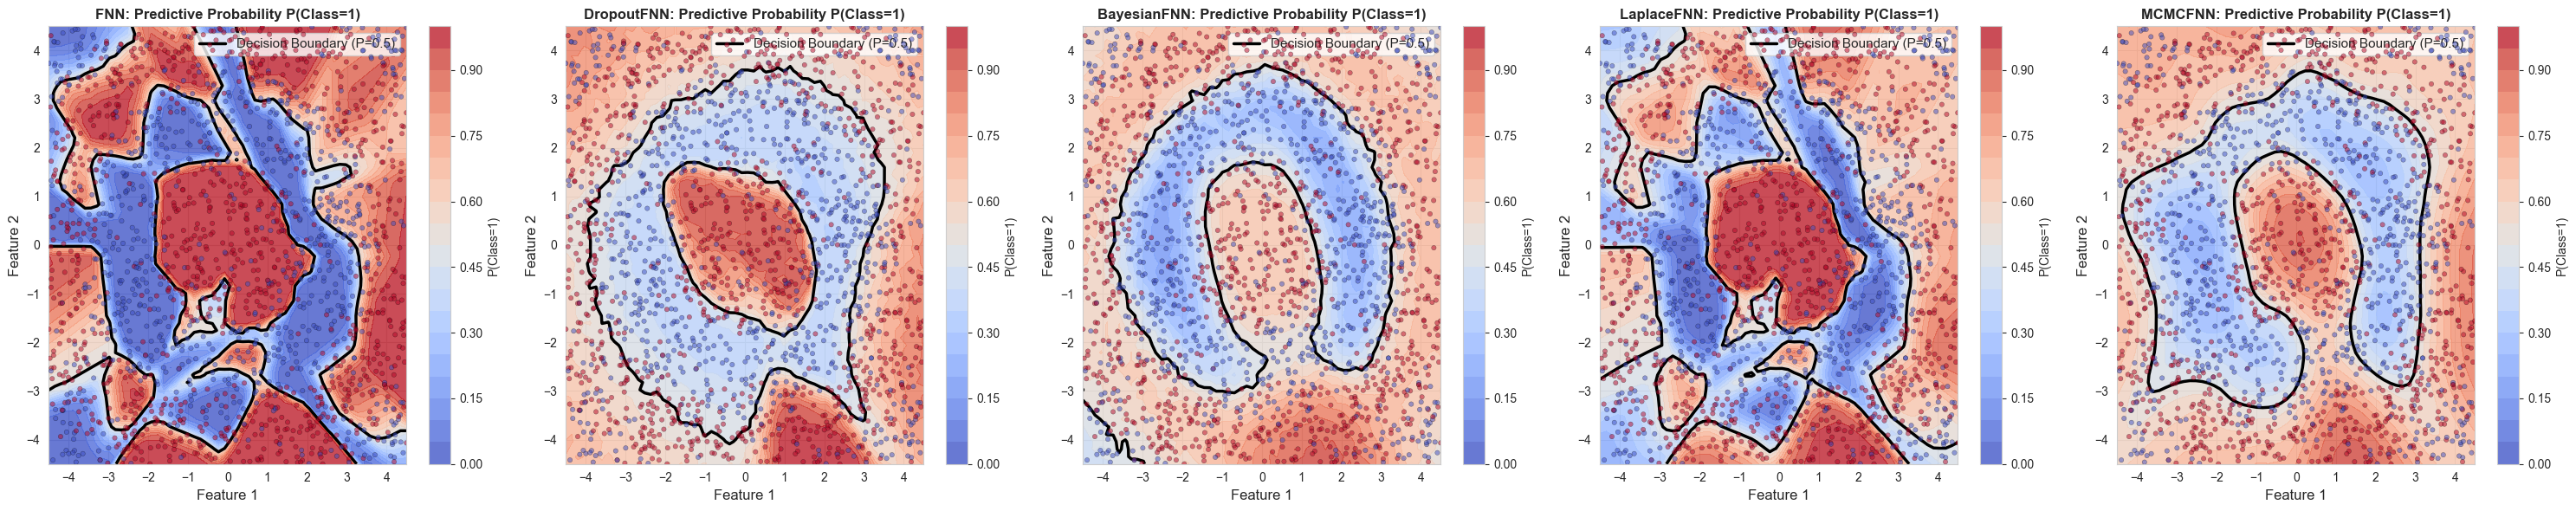

In [21]:
# Plot predictive posteriors for all models using the grid wrapper
plot_posterior_grid(all_results, X_test, y_test, seed=seed, figures_dir=figures_dir)

### Predictive Posterior: Observations

**Comparison to ground truth (concentric rings):**

1. **FNN**: Captures the general ring structure but with sharp, overconfident probability transitions. The decision boundaries are jagged, and the probability gradients don't match the smooth ground truth.

2. **DropoutFNN**: Slightly smoother probability field than FNN. MC Dropout adds some uncertainty, softening the sharp transitions, but the uncertainty is applied uniformly rather than being data-dependent. The central region is miscalibrated.

3. **BayesianFNN**: Shows the smoothest probability gradients among training-time methods. The learned weight uncertainty translates to appropriately uncertain predictions near decision boundaries.

4. **LaplaceFNN**: Inherits the decision boundaries from the base FNN but with softened probabilities. The Laplace correction adds uncertainty that lessens extreme confidence values. We still see some overly confident regions.

5. **MCMCFNN**: Produces well-calibrated probability maps. The full posterior sampling results in smooth transitions that better approximate the ground truth probability field.

**Takeaway**: All models capture the concentric ring structure, but Bayesian methods produce probability fields that more closely match the smooth ground truth. The deterministic FNN shows the sharpest (most overconfident) transitions.


## 6. Uncertainty Quantification

We visualize **predictive uncertainty** using **entropy**:

$$H(\mathbf{x}) = -\sum_{c} P(y=c | \mathbf{x}) \log P(y=c | \mathbf{x})$$

For binary classification, maximum entropy occurs at $P = 0.5$ (complete uncertainty), while $P \in \{0, 1\}$ gives zero entropy (complete confidence).

**What to look for:**
- **High entropy regions** (bright colors) should align with decision boundaries ($P = 0.5$ contours)
- **Low entropy regions** (dark colors) should appear where the model is confident
- **Ground truth comparison**: Uncertainty should match the true probability field—high where ground truth is near 0.5



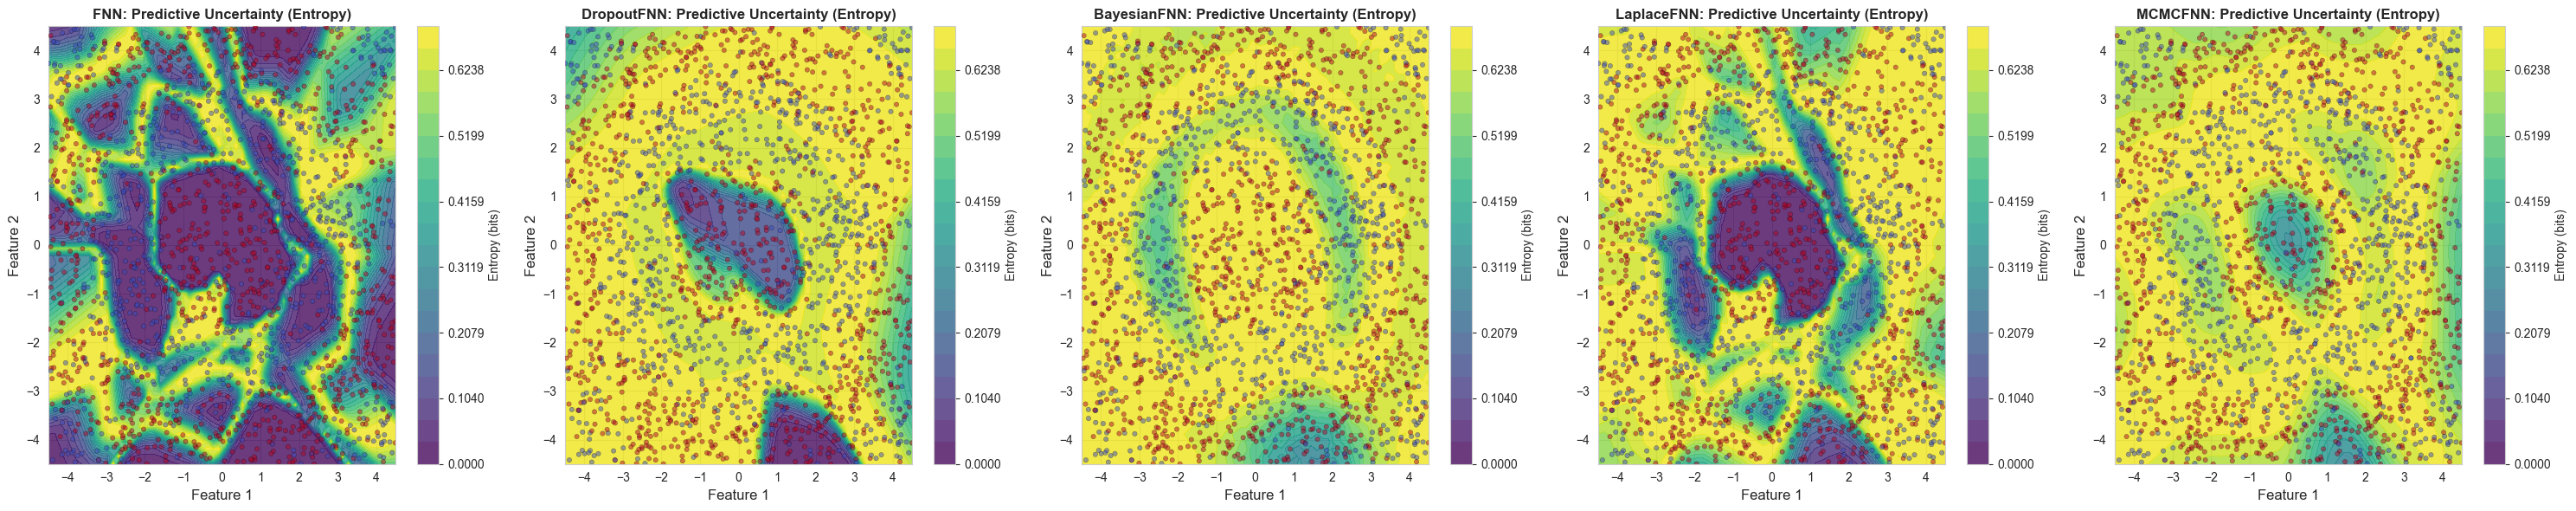

In [22]:
# Plot uncertainty (entropy) for all models using the grid wrapper
plot_uncertainty_grid(all_results, X_test, y_test, seed=seed, figures_dir=figures_dir)

### Uncertainty Quantification: Observations

**Comparing uncertainty patterns across methods:**

1. **FNN**: Shows very low uncertainty everywhere except at decision boundaries. This is the classic overconfidence problem—the model is certain even in regions where the ground truth has significant uncertainty.

2. **DropoutFNN**: Broader uncertainty bands around decision boundaries compared to FNN. However, regions 'interior' to the decision boundary appear as overly confident 'holes' of near-certainty.

3. **BayesianFNN**: The learned weight uncertainty produces uncertainty estimates that better reflect the true probability field around decision boundaries, but the model fails to capture 'lower entropy' in the center.

4. **LaplaceFNN**: Similar to the DropoutFNN, the Laplace Redux model inherits overly confident 'interior' holes from the FFN model, but gains broad uncertainty bands around decision boundaries.

5. **MCMCFNN**: Shows the most data-driven uncertainty pattern. High uncertainty regions correspond well to where the ground truth probability is ambiguous. We see a ring-like entropy structure with a well-calibrated center.

**Takeaway**: Bayesian methods (especially MCMCFNN and BayesianFNN) produce uncertainty estimates that extend appropriately into regions of genuine ambiguity, rather than just marking decision boundaries. This is crucial for downstream applications like active learning or out-of-distribution detection.


## Summary

This notebook demonstrates five uncertainty quantification methods:

| Method | Type | Training | Inference |
|--------|------|----------|-----------|
| **FNN** | Deterministic | Standard SGD | Single forward pass |
| **DropoutFNN** | Approximate Bayesian | Standard SGD | MC Dropout Sampling |
| **BayesianFNN** | Variational Inference | ELBO optimization | VI Posterior Sampling |
| **LaplaceFNN** | Post-hoc Bayesian | MAP + Hessian | Sampling Laplace Approx. around MAP |
| **MCMCFNN** | Exact Bayesian | NUTS sampling | Sample weights from true posterior |

### Key Observations

1. **Calibration**: Bayesian methods (VI, Laplace, MCMC) typically improve calibration over deterministic baselines
2. **Computational Trade-offs**:
   - MCMC provides asymptotically exact inference but is slow
   - Laplace is fast (post-hoc) but relies on MAP (FFN) decision boundary.
   - VI (Bayes by Backprop) balances accuracy and speed
   - MC Dropout is a simple heuristic that performs surprisingly well in-practice.
3. **Uncertainty Quantification**: All Bayesian methods provide meaningful uncertainty estimates in ambiguous regions

